In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

In [3]:
from pathlib import Path
from fastai.basic_train import load_learner

In [4]:
model_path = Path("/home/jupyter/models/")

In [5]:
learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
cnn = learner.model[0][0]

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [13]:
arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

In [9]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

path = '../../images/style-transfer/'
style_img = image_loader(path + "picasso.jpg")
content_img = image_loader(path + "dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

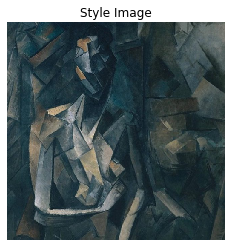

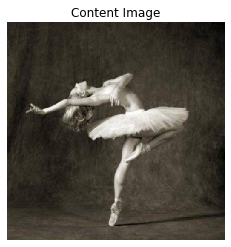

In [10]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

torch.Size([1, 3, 512, 512])

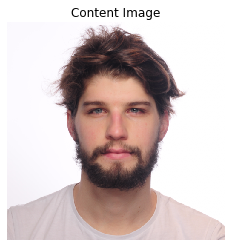

In [16]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
plt.figure()
imshow(content_img, title='Content Image')

content_img.shape

(None, torch.Size([1, 3, 512, 512]))

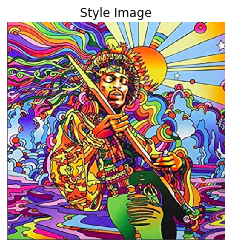

In [17]:

style_img = style_img[:, :3, :, :512]
plt.figure()
imshow(style_img, title='Style Image'), style_img.shape

In [37]:
style_injects = [f'conv-{i}' for i in range(12)]
content_injects = ['conv-3', "conv-4", "conv-5"]

In [38]:
style_module = StyleTransferModule(arch, content_img, content_injects, style_img, style_injects)

In [39]:
[m.target.sum() for m in style_module.layers.values() if isinstance(m, StyleLoss)]

[tensor(1.6656, device='cuda:0'),
 tensor(72.7038, device='cuda:0'),
 tensor(1127.2092, device='cuda:0'),
 tensor(1613.3574, device='cuda:0'),
 tensor(9319.0186, device='cuda:0'),
 tensor(19561.5039, device='cuda:0'),
 tensor(21192.7930, device='cuda:0'),
 tensor(68152.3906, device='cuda:0'),
 tensor(115001.0781, device='cuda:0'),
 tensor(106358.8984, device='cuda:0'),
 tensor(64200.6406, device='cuda:0'),
 tensor(44928.6094, device='cuda:0')]

In [40]:
[m.target.sum() for m in style_module.layers.values() if isinstance(m, ContentLoss)]

[tensor(-8951027., device='cuda:0'),
 tensor(-4041500., device='cuda:0'),
 tensor(-6542444., device='cuda:0')]

Next, we select the input image. You can use a copy of the content image
or white noise.




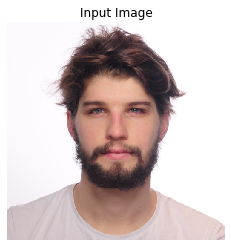

In [41]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Finally, we can run the algorithm.




Optimizing...
run [50]:
Style Loss : 22756.734375 Content Loss: 474.086304

run [100]:
Style Loss : 5868.494629 Content Loss: 487.387146

run [150]:
Style Loss : 3253.803711 Content Loss: 492.469177

run [200]:
Style Loss : 2093.200928 Content Loss: 492.111267

run [250]:
Style Loss : 1492.875610 Content Loss: 496.003967

run [300]:
Style Loss : 1303.809326 Content Loss: 494.704163



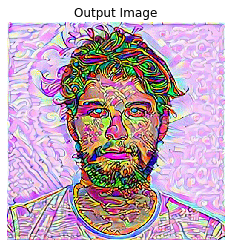

In [42]:
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img, num_steps=600)

output = style_module.run_style_transfer(input_img, num_steps=300, tv_weight=0.001 )

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Optimizing...
run [50]:
Style Loss : 21483.785156 Content Loss: 471.509918

run [100]:
Style Loss : 6973.747559 Content Loss: 484.717224

run [150]:
Style Loss : 6147.627441 Content Loss: 490.666840

run [200]:
Style Loss : 2286.103516 Content Loss: 495.210999

run [250]:
Style Loss : 1516.623047 Content Loss: 496.476562

run [300]:
Style Loss : 1185.599854 Content Loss: 498.041229



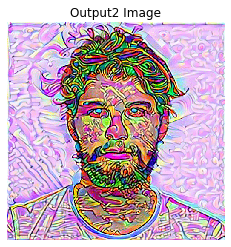

In [43]:
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img, num_steps=600)

#tv == total_variation loss
output2 = style_module.run_style_transfer(input_img, num_steps=300, tv_weight=0.005 )

plt.figure()
imshow(output2, title='Output2 Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

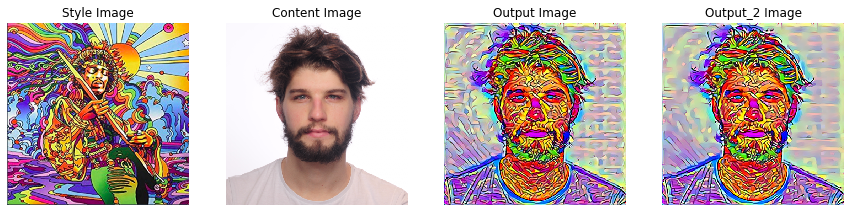

In [28]:
_, ax = plt.subplots(1, 4, figsize=(15,6))
imshow(style_img, title='Style Image', ax=ax[0])
imshow(content_img, title='Content Image', ax=ax[1])
imshow(output, title='Output Image', ax=ax[2])
imshow(output2, title='Output_2 Image', ax=ax[3])